# **LAB 6 Classic architectures of Convolutional Neural Network**


## Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import os

from bs4 import BeautifulSoup
import requests
import cv2
import PIL.Image
import urllib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import keras
from keras.datasets import cifar10, cifar100, mnist, fashion_mnist
from keras.utils import to_categorical
from keras import models, layers
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Conv2D, Dropout, Activation, MaxPooling2D, Input
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Colab new.zip'
!unzip Colab.zip

## Loading The Data

### Importing Train Data From CIFAR10

In [ ]:
(c10x_train, c10y_train), (c10x_test, c10y_test) = cifar10.load_data()

c10x_train = c10x_train.reshape(c10x_train.shape[0], 32, 32, 3)
c10x_train = c10x_train.astype('float32')

c10x_train = preprocess_input(c10x_train)
c10x_test = preprocess_input(c10x_test)

c10y_train = to_categorical(c10y_train)
c10y_test = to_categorical(c10y_test)

print('x_train shape:', c10x_train.shape)
print(c10x_train.shape[0], 'train samples')

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples


### Importing Train Data From CIFAR100

In [ ]:
(c100x_train, c100y_train), (c100x_test, c100y_test) = cifar100.load_data()

c100x_train = c100x_train.reshape(c100x_train.shape[0], 32, 32, 3)
c100x_train = c100x_train.astype('float32')
c100x_train /= 255

c100y_train = to_categorical(c100y_train)
c100y_test = to_categorical(c100y_test)

print('x_train shape:', c100x_train.shape)
print(c100x_train.shape[0], 'train samples')

169009152/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples


### Importing Train Data From MNIST

In [ ]:
(mnx_train, mny_train), (mnx_test, mny_test) = mnist.load_data()

mnx_train = mnx_train.reshape(mnx_train.shape[0], 28, 28, 1)
mnx_train = mnx_train.astype('float32')
mnx_train /= 255

mny_train = to_categorical(mny_train)
mny_test = to_categorical(mny_test)

print('x_train shape:', mnx_train.shape)
print(mnx_train.shape[0], 'train samples')

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples


### Importing Train Data From Fashion MNIST

In [ ]:
(fmnx_train, fmny_train), (fmnx_test, fmny_test) = fashion_mnist.load_data()

fmnx_train = fmnx_train.reshape(fmnx_train.shape[0], 28, 28, 1)
fmnx_train = fmnx_train.astype('float32')
fmnx_train /= 255

fmny_train = to_categorical(fmny_train)
fmny_test = to_categorical(fmny_test)

print('x_train shape:', fmnx_train.shape)
print(fmnx_train.shape[0], 'train samples')

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples


### Loading The Dev and Test Set from ImageNet

#### Extracting Images From Website

In [ ]:
def url_to_image(url):
    webpage = urllib.request.urlopen(url) # Open the website URL
    image = np.asarray(bytearray(webpage.read()), dtype="uint8") # Load the image from the page
    image = cv2.imdecode(image, cv2.IMREAD_COLOR) # Decode to a more suitable format
    return image # Return the read image

In [ ]:
def get_images(url, n_samples, path):
    #Getting the image links and splitting them after converting to sting
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    str_soup = str(soup)
    
    urls = str_soup.split('\r\n')
    print('No. of URLs is:', len(urls))

    #Saving The Train Data
    i, count = 0, 0
    while 1:
        if count % 10 == 0: print('No. of Images Loaded: ', count)
        if not urls[i] == None:
            try:
                img = url_to_image(urls[i])
                if (len(img.shape)) == 3:
                    save_path = path + str(count) + '.jpg'
                    img = cv2.resize(img, (32, 32))
                    cv2.imwrite(save_path, img)
                    count += 1
            except: None

        i += 1
        if count >= n_samples: break

In [ ]:
# Cats
cats = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02123045"
cat_data = '/Users/nmims/Desktop/Semester VI/Deep Learning/Experiment 4/cats/cats'
get_images(cats, 200, cat_data)

In [ ]:
# Dogs
dogs = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02084071"
dog_data = '/Users/nmims/Desktop/Semester VI/Deep Learning/Experiment 4/dogs/dogs'
get_images(dogs, 200, dog_data)

#### Loading Images from Stored Folder to Code

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images

In [ ]:
def get_array(folder):
    arrays = load_images_from_folder(folder)
    print('No of images found in class:', len(arrays))
    
    images =[]
    for i in range(len(arrays)):
        arr = arrays[i].reshape((arrays[i].shape[0] * arrays[i].shape[1] * arrays[i].shape[2]))
        images = np.append(images, arr)
    
    images = images.reshape((len(arrays), 128, 128, 3))
    return images, len(arrays)

In [ ]:
folder = '/content/Colab/cats'
cat, count = get_array(folder)
y_temp = np.array([0 for i in range(count)])
print('Read Cats')

folder = '/content/Colab/dogs'
dog, count = get_array(folder)
y = np.append(y_temp, np.array([1 for i in range(count)]))
print('Read Dogs')

x = np.vstack((cat, dog))
x = x / 255
y = to_categorical(y)
print(x.shape)
print(y.shape)

No of images found in class: 200
Read Cats
No of images found in class: 200
Read Dogs
(400, 128, 128, 3)
(400, 2)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle = True, test_size = 0.5)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(200, 128, 128, 3) (200, 128, 128, 3)
(200, 2) (200, 2)


### Visualizing The Train Data

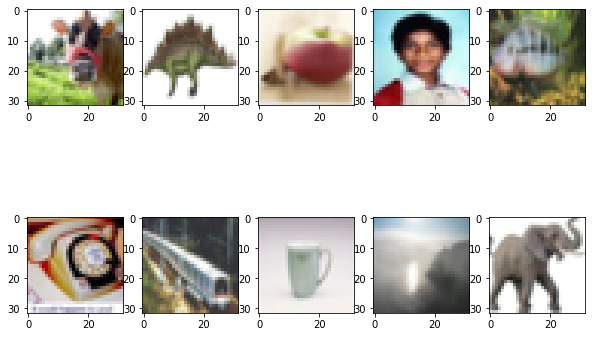

In [ ]:
fig  = plt.figure(figsize = (10, 7))
i = 0
for i in range(10):
    pl = fig.add_subplot(2, 5, i + 1)
    pl.imshow(c100x_train[i], cmap='gray')
    i += 1

## Model Building

### VGG16 Model

In [ ]:
def vg_16(params, compilation, input_shape = 32, channel = 3):
  vgg16 = VGG16(weights = None, include_top = False, 
                input_tensor = Input(shape = (input_shape, input_shape, channel)))
  # Adding our own output layer to the VGG16 Architecture
  out = Sequential()
  out.add(Flatten())
  out.add(Dense(params['output'], activation = params['activation']))

  vgg16 = Model(inputs = vgg16.input, outputs = out(vgg16.output))

  vgg16.compile(loss = compilation['loss'], optimizer = compilation['optimizer'], metrics = compilation['metrics'])
  return vgg16

#### CIFAR10

In [ ]:
compilation = {'optimizer' : 'adam', 'loss' : 'categorical_crossentropy', 
               'metrics' : ['accuracy']}
params = {'output' : 10, 'activation' : 'softmax'}
model = vg_16(params = params, compilation = compilation, input_shape = 32, channel = 3)
model.fit(c10x_train, c10y_train, epochs = 10, batch_size = 500)
_, acc = model.evaluate(c10x_test, c10y_test)
print('The Model accuracy is:', acc * 100)

Epoch 1/10
100/100 [==============================] - 53s 143ms/step - loss: 2.9261 - accuracy: 0.1343
Epoch 2/10
100/100 [==============================] - 15s 146ms/step - loss: 1.7810 - accuracy: 0.3064
Epoch 3/10
100/100 [==============================] - 15s 149ms/step - loss: 1.4110 - accuracy: 0.4693
Epoch 4/10
100/100 [==============================] - 15s 153ms/step - loss: 1.1296 - accuracy: 0.5861
Epoch 5/10
100/100 [==============================] - 16s 155ms/step - loss: 0.8948 - accuracy: 0.6793
Epoch 6/10
100/100 [==============================] - 16s 158ms/step - loss: 0.7621 - accuracy: 0.7281
Epoch 7/10
100/100 [==============================] - 16s 156ms/step - loss: 0.6377 - accuracy: 0.7749
Epoch 8/10
100/100 [==============================] - 15s 154ms/step - loss: 0.5464 - accuracy: 0.8098
Epoch 9/10
100/100 [==============================] - 15s 154ms/step - loss: 0.4503 - accuracy: 0.8408
Epoch 10/10
313/313 [==============================] - 4s 9ms/step - loss

#### CIFAR100

In [ ]:
compilation = {'optimizer' : 'adam', 'loss' : 'categorical_crossentropy', 
               'metrics' : ['accuracy']}
params = {'output' : 100, 'activation' : 'softmax'}
model = vg_16(params = params, compilation = compilation, input_shape = 32, channel = 3)
model.fit(c100x_train, c100y_train, epochs = 10, batch_size = 500)

_, acc = model.evaluate(c100x_test, c100y_test)
print('The Model accuracy on test set:', acc * 100)

Epoch 1/10
100/100 [==============================] - 10s 93ms/step - loss: 4.6158 - accuracy: 0.0098
Epoch 2/10
100/100 [==============================] - 9s 93ms/step - loss: 4.6053 - accuracy: 0.0095
Epoch 3/10
100/100 [==============================] - 9s 93ms/step - loss: 4.6053 - accuracy: 0.0097
Epoch 4/10
100/100 [==============================] - 9s 93ms/step - loss: 4.6053 - accuracy: 0.0094
Epoch 5/10
100/100 [==============================] - 9s 92ms/step - loss: 4.6052 - accuracy: 0.0098
Epoch 6/10
100/100 [==============================] - 9s 93ms/step - loss: 4.6053 - accuracy: 0.0087
Epoch 7/10
100/100 [==============================] - 9s 93ms/step - loss: 4.6052 - accuracy: 0.0104
Epoch 8/10
100/100 [==============================] - 9s 92ms/step - loss: 4.6053 - accuracy: 0.0097
Epoch 9/10
100/100 [==============================] - 9s 92ms/step - loss: 4.6053 - accuracy: 0.0091
Epoch 10/10
313/313 [==============================] - 2s 7ms/step - loss: 4.6046 - accura

#### ImageNet Cat-Dog

In [ ]:
compilation = {'optimizer' : 'adam', 'loss' : 'binary_crossentropy', 
               'metrics' : ['accuracy']}
params = {'output' : 2, 'activation' : 'sigmoid'}
model = vg_16(params = params, compilation = compilation, input_shape = 128, channel = 3)
model.fit(x_train, y_train, epochs = 10, batch_size = 500)

_, acc = model.evaluate(x_test, y_test)
print('The Model accuracy on test set:', acc * 100)

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.6931 - accuracy: 0.5050
Epoch 2/10
1/1 [==============================] - 0s 396ms/step - loss: 0.6969 - accuracy: 0.5050
Epoch 3/10
1/1 [==============================] - 0s 397ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 4/10
1/1 [==============================] - 0s 390ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 5/10
1/1 [==============================] - 0s 396ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 6/10
1/1 [==============================] - 0s 399ms/step - loss: 0.6930 - accuracy: 0.5050
Epoch 7/10
1/1 [==============================] - 0s 388ms/step - loss: 0.6925 - accuracy: 0.5050
Epoch 8/10
1/1 [==============================] - 0s 395ms/step - loss: 0.6918 - accuracy: 0.5050
Epoch 9/10
1/1 [==============================] - 0s 388ms/step - loss: 0.6935 - accuracy: 0.4950
Epoch 10/10
7/7 [==============================] - 2s 81ms/step - loss: 0.6931 - accuracy: 0.5050
The Model accuracy on t

### VGG19

In [ ]:
def vg_19(params, compilation, input_shape = 32, channel = 3):
  vgg19 = VGG19(weights = None, include_top = False, 
                input_tensor = Input(shape = (input_shape, input_shape, channel)))
  # Adding our own output layer to the VGG19 Architecture
  out = Sequential()
  out.add(Flatten())
  out.add(Dense(params['output'], activation = params['activation']))

  vgg19 = Model(inputs = vgg19.input, outputs = out(vgg19.output))

  vgg19.compile(loss = compilation['loss'], optimizer = compilation['optimizer'], metrics = compilation['metrics'])
  return vgg19

#### CIFAR10

In [ ]:
compilation = {'optimizer' : 'rmsprop', 'loss' : 'categorical_crossentropy', 
               'metrics' : ['accuracy']}
params = {'output' : 10, 'activation' : 'softmax'}
model = vg_19(params = params, compilation = compilation, input_shape = 32, channel = 3)
model.fit(c10x_train, c10y_train, epochs = 10, batch_size = 500)

_, acc = model.evaluate(c10x_test, c10y_test)
print('The Model accuracy on test set:', acc * 100)

Epoch 1/10
100/100 [==============================] - 13s 115ms/step - loss: 28465.7512 - accuracy: 0.0979
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 2.3904 - accuracy: 0.1285
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 2.4786 - accuracy: 0.1008
Epoch 4/10
100/100 [==============================] - 11s 115ms/step - loss: 2.3824 - accuracy: 0.1017
Epoch 5/10
100/100 [==============================] - 11s 115ms/step - loss: 3.1157 - accuracy: 0.1123
Epoch 6/10
100/100 [==============================] - 12s 115ms/step - loss: 2.3741 - accuracy: 0.1053
Epoch 7/10
100/100 [==============================] - 12s 115ms/step - loss: 2.5960 - accuracy: 0.1153
Epoch 8/10
100/100 [==============================] - 12s 115ms/step - loss: 2.3401 - accuracy: 0.1255
Epoch 9/10
100/100 [==============================] - 12s 115ms/step - loss: 2.7978 - accuracy: 0.1553
Epoch 10/10
313/313 [==============================] - 3s 8ms/step - 

#### CIFAR100

In [ ]:
compilation = {'optimizer' : 'rmsprop', 'loss' : 'categorical_crossentropy', 
               'metrics' : ['accuracy']}
params = {'output' : 100, 'activation' : 'softmax'}
model = vg_19(params = params, compilation = compilation, input_shape = 32, channel = 3)
model.fit(c100x_train, c100y_train, epochs = 10, batch_size = 500)

_, acc = model.evaluate(c100x_test, c100y_test)
print('The Model accuracy on test set:', acc * 100)

Epoch 1/10
100/100 [==============================] - 13s 115ms/step - loss: 4.6219 - accuracy: 0.0098
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0093
Epoch 3/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0097
Epoch 4/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0090
Epoch 5/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0081
Epoch 6/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0095
Epoch 7/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0097
Epoch 8/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0094
Epoch 9/10
100/100 [==============================] - 11s 115ms/step - loss: 4.6053 - accuracy: 0.0097
Epoch 10/10
313/313 [==============================] - 3s 8ms/step - loss

#### ImageNet Cat-Dog

In [ ]:
compilation = {'optimizer' : 'adam', 'loss' : 'binary_crossentropy', 
               'metrics' : ['accuracy']}
params = {'output' : 2, 'activation' : 'sigmoid'}
model = vg_19(params = params, compilation = compilation, input_shape = 128, channel = 3)
model.fit(x_train, y_train, epochs = 10, batch_size = 500)

_, acc = model.evaluate(x_test, y_test)
print('The Model accuracy on test set:', acc * 100)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6932 - accuracy: 0.4950
Epoch 2/10
1/1 [==============================] - 0s 463ms/step - loss: 0.6930 - accuracy: 0.5050
Epoch 3/10
1/1 [==============================] - 0s 462ms/step - loss: 0.7001 - accuracy: 0.5050
Epoch 4/10
1/1 [==============================] - 0s 465ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 5/10
1/1 [==============================] - 0s 465ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 6/10
1/1 [==============================] - 0s 466ms/step - loss: 0.6932 - accuracy: 0.4950
Epoch 7/10
1/1 [==============================] - 0s 464ms/step - loss: 0.6931 - accuracy: 0.5050
Epoch 8/10
1/1 [==============================] - 0s 457ms/step - loss: 0.6931 - accuracy: 0.5050
Epoch 9/10
1/1 [==============================] - 0s 457ms/step - loss: 0.6931 - accuracy: 0.5050
Epoch 10/10
7/7 [==============================] - 0s 24ms/step - loss: 0.6934 - accuracy: 0.4950
The Model accuracy on t

## Deployment

In [ ]:
!pip install flask-ngrok
!pip install flask gevent requests pillow
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

In [ ]:
procfile = 'web: gunicorn app:app'
procfiles= open("Procfile","w")
procfiles.write(procfile)
procfiles.close()

In [ ]:
app = Flask(__name__)
run_with_ngrok(app)

app.config['UPLOADS'] = 'uploads'

def bestModel():
    global mymodel
    mymodel = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning/catDog.h5')

@app.route('/')
def home():
    return render_template('index.html')

def predicting(file):
    img = cv2.imread(file)
    img = cv2.resize(img, (32, 32))
    img = np.resize(img, (1, 32, 32, 3)) / 255
    pred = mymodel.predict(img)
    if pred > 0.5: return 'dog'
    else: return 'cat'

@app.route('/', methods = ['POST'])
def upload_files():
    file = request.files['file']
    animal = request.form['animal']
    for_file = int(animal)
    if for_file == 0: animal = 'cat'
    else: animal = 'dog'
    
    filepath = os.path.join(app.config['UPLOADS'], animal, file.filename)
    file.save(filepath)
    
    pred = predicting(filepath)
    
    # Documentating The Results
    doc = pd.read_csv('documentation.csv')
    if pred =='cat': out = 0
    else: out = 1
    doc.loc[len(doc)] = [file.filename, for_file, out]
    doc.to_csv('documentation.csv', index = False)
    
    return render_template('index.html', label = pred)

def updateModel():
    folder = '/content/uploads/cat'
    cat, count = get_array(folder)
    y_temp = np.array([0 for i in range(count)])

    folder = '/content/uploads/dog'
    dog, count = get_array(folder)
    y = np.append(y_temp, np.array([1 for i in range(count)]))

    x = np.vstack((cat, dog))
    x = x / 255
    mymodel.fit(x, y, epochs = 10)
    # If you want to save the newer version of the model overwriting the previous version
    # models.save_model(mymodel, 'catDog.h5')

if __name__ == '__main__':
    bestModel()
    '''
    Optional, if we want to retrain the model based on the input it has already saved from uploads
    Make sure after training on the upload data, the upload folder is cleared, otherwise it would train on the
    the same uploaded data again and again.
    '''
    # updateModel()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Mar/2021 07:04:45] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 07:04:45] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 07:04:45] "POST / HTTP/1.1" 200 -


 * Running on http://f8fcb810b5c0.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [19/Mar/2021 07:04:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Mar/2021 07:04:50] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Mar/2021 07:05:00] "POST / HTTP/1.1" 200 -
